In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
%pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


Note: you may need to restart the kernel to use updated packages.


In [4]:
# Load the data
data = pd.read_csv("capstone_datasource_masked.csv")

In [5]:
data.info

<bound method DataFrame.info of                                       REDACTED_APPUSERID  \
0      df********************************************...   
1      a0********************************************...   
2      a0********************************************...   
3      a0********************************************...   
4      a7********************************************...   
...                                                  ...   
12590  c2********************************************...   
12591  c2********************************************...   
12592  c2********************************************...   
12593  c2********************************************...   
12594  c2********************************************...   

      REDACTED_ARTICLE_NUMBER  \
0                   KB*****47   
1                   KB*****28   
2                   KB*****84   
3                   KB*****26   
4                   KB*****04   
...                       ...   
12590           

In [6]:
data.head(2)

,REDACTED_APPUSERID,REDACTED_ARTICLE_NUMBER,REDACTED_ARTICLE_TITLE,REDACTED_COMPANY,CONTENT_TYPE,TITLE,DV_U_JOB_FUNCTION,REDACTED_EMAIL
0,df********************************************...,KB*****47,Ho**********************************er,Mo**********c.,Support and Troubleshooting,Other,Accounting Shared Services,sa**********************om
1,a0********************************************...,KB*****28,Fa***************************st,Sh*****LC,CORE,Sr. IT Ops Manager,Accounting Shared Services,Ma***********************om


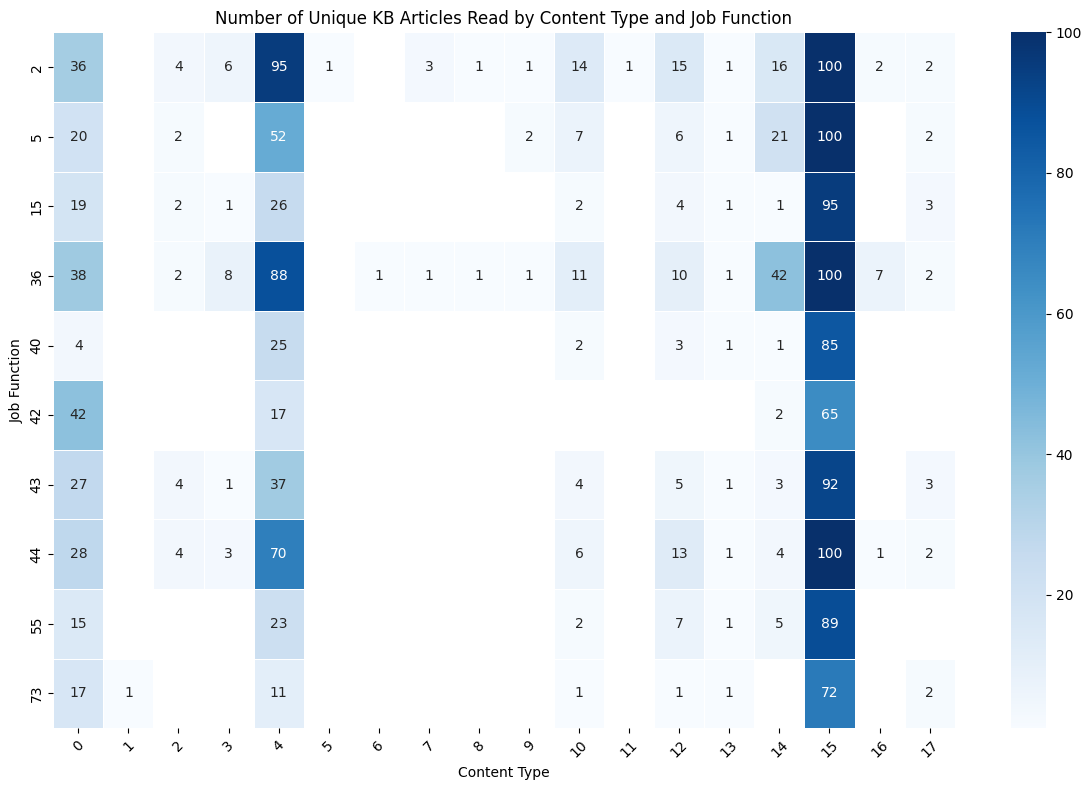

In [43]:
# Group data to calculate the number of unique KB articles read by content type for each job function
unique_kbs_data = (
    filtered_data.groupby(['DV_U_JOB_FUNCTION', 'CONTENT_TYPE'])['REDACTED_ARTICLE_NUMBER']
    .nunique()
    .reset_index(name='Unique_KB_Count')
)

# Pivot the data for heatmap visualization
pivot_data = unique_kbs_data.pivot(
    index='DV_U_JOB_FUNCTION', columns='CONTENT_TYPE', values='Unique_KB_Count'
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_data,
    annot=True,
    fmt=".0f",
    cmap="Blues",
    linewidths=0.5
)
plt.title("Number of Unique KB Articles Read by Content Type and Job Function")
plt.xlabel("Content Type")
plt.ylabel("Job Function")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


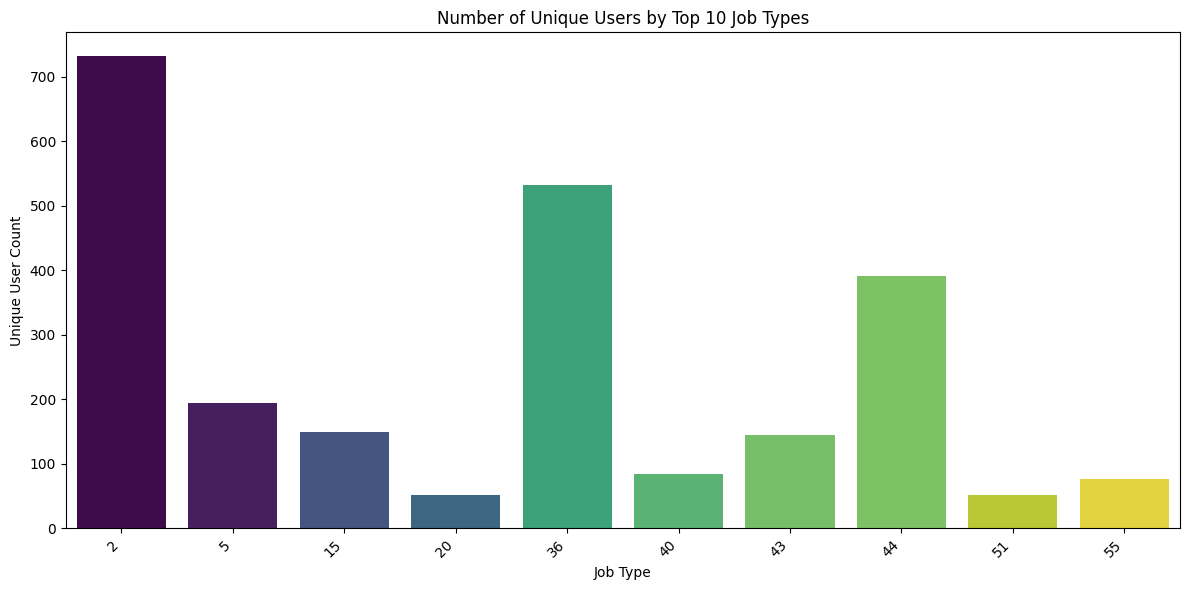

In [53]:
# Group the data to calculate the number of unique users by job type
unique_users_data = data.groupby('DV_U_JOB_FUNCTION')['REDACTED_APPUSERID'].nunique().reset_index(name='Unique_User_Count')

# Get the top 10 job types by the number of unique users
top_10_jobs = unique_users_data.nlargest(10, 'Unique_User_Count')

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_10_jobs,
    x='DV_U_JOB_FUNCTION',
    y='Unique_User_Count',
    hue='DV_U_JOB_FUNCTION',  # Assign the `x` variable to `hue`
    dodge=False,  # Prevent stacking since it's a single category
    palette="viridis"
)
plt.title("Number of Unique Users by Top 10 Job Types")
plt.xlabel("Job Type")
plt.ylabel("Unique User Count")
plt.xticks(rotation=45, ha='right')
plt.legend([], [], frameon=False)  # Disable legend for clarity
plt.tight_layout()
plt.show()


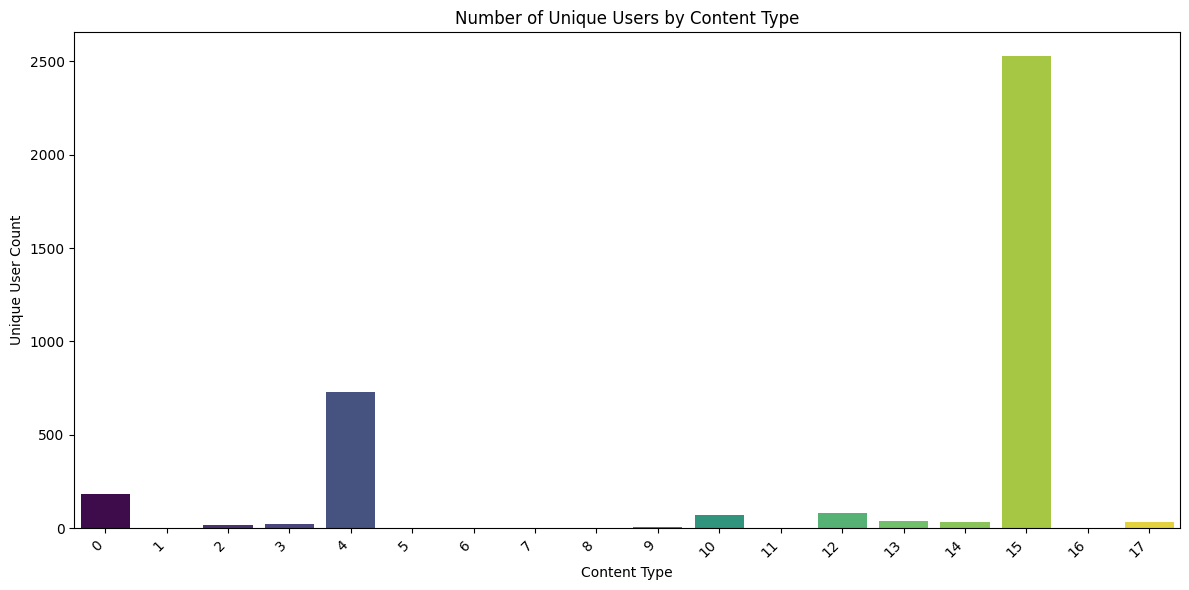

In [56]:
# Group the data to calculate the number of unique users by content type
unique_users_content = data.groupby('CONTENT_TYPE')['REDACTED_APPUSERID'].nunique().reset_index(name='Unique_User_Count')

# Sort by the number of unique users for better visualization
unique_users_content = unique_users_content.sort_values(by='Unique_User_Count', ascending=False)

# Plot using seaborn
# Update the plot to address the future warning by using `hue` with the `x` variable
plt.figure(figsize=(12, 6))
sns.barplot(
    data=unique_users_content,
    x='CONTENT_TYPE',
    y='Unique_User_Count',
    hue='CONTENT_TYPE',  # Assign the `x` variable to `hue`
    dodge=False,  # Ensure no stacking
    palette="viridis"
)
plt.title("Number of Unique Users by Content Type")
plt.xlabel("Content Type")
plt.ylabel("Unique User Count")
plt.xticks(rotation=45, ha='right')
plt.legend([], [], frameon=False)  # Disable the legend for clarity
plt.tight_layout()
plt.show()



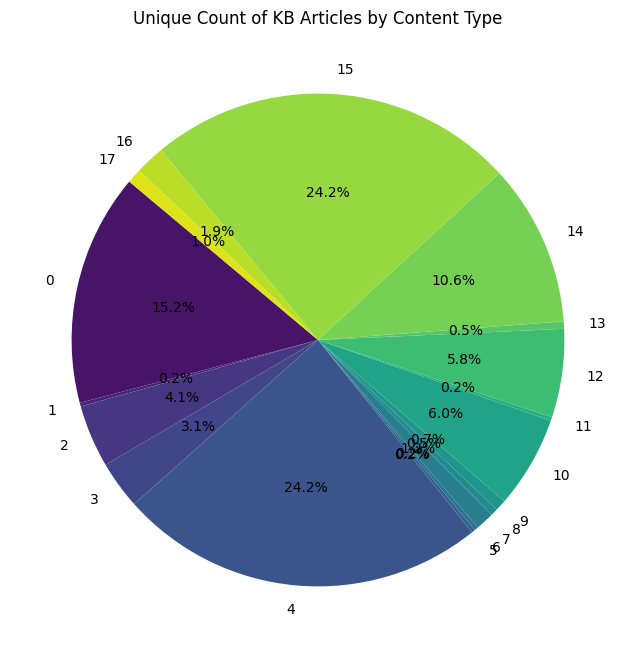

In [59]:
# Group the data to calculate the unique count of KB articles by content type
unique_kbs_content = data.groupby('CONTENT_TYPE')['REDACTED_ARTICLE_NUMBER'].nunique().reset_index(name='Unique_KB_Count')

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    unique_kbs_content['Unique_KB_Count'],
    labels=unique_kbs_content['CONTENT_TYPE'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("viridis", len(unique_kbs_content))
)
plt.title("Unique Count of KB Articles by Content Type")
plt.show()


1.What KB articles users with similar profile are interested to view?

In [9]:
# Group data by job function and job title and count KB article views
kb_interest_by_profile = data.groupby(
    ['DV_U_JOB_FUNCTION', 'TITLE', 'REDACTED_ARTICLE_NUMBER']
).size().reset_index(name='view_count')

In [10]:
# Sort by job function, title, and most-viewed articles
kb_interest_by_profile_sorted = kb_interest_by_profile.sort_values(
    ['DV_U_JOB_FUNCTION', 'TITLE', 'view_count'], ascending=[True, True, False]
)

In [7]:
# Prepare the data for Linear Regression and Classification
# Encode categorical variables
label_encoders = {}
categorical_columns = ['DV_U_JOB_FUNCTION', 'TITLE', 'CONTENT_TYPE']

for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [11]:
# For Linear Regression
X_reg = data[['DV_U_JOB_FUNCTION', 'TITLE', 'CONTENT_TYPE']]
y_reg = kb_interest_by_profile_sorted['view_count']

In [12]:
# For Classification (binary target: view/not view for a specific KB article)
# Create a binary target variable: e.g., if 'KB*****47' was viewed or not
specific_kb = 'KB*****47'
data['view_specific_kb'] = (data['REDACTED_ARTICLE_NUMBER'] == specific_kb).astype(int)
X_clf = data[['DV_U_JOB_FUNCTION', 'TITLE', 'CONTENT_TYPE']]
y_clf = data['view_specific_kb']

In [22]:
available_columns = data.columns
available_columns

Index(['REDACTED_APPUSERID', 'REDACTED_ARTICLE_NUMBER',
       'REDACTED_ARTICLE_TITLE', 'REDACTED_COMPANY', 'CONTENT_TYPE', 'TITLE',
       'DV_U_JOB_FUNCTION', 'REDACTED_EMAIL', 'view_specific_kb'],
      dtype='object')

In [24]:
# Use the existing columns to align feature matrix and target variables
X_reg = data[['DV_U_JOB_FUNCTION', 'TITLE', 'CONTENT_TYPE']]
y_reg = data['view_specific_kb']

In [27]:
# Verify the lengths to ensure alignment
len_X = len(X_reg)
len_y = len(y_reg)
len_X, len_y

(12595, 12595)

In [28]:
# Split the data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

In [29]:
# Train Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_reg, y_train_reg)

LinearRegression()

In [30]:
# Predict and evaluate Linear Regression
y_pred_reg = linear_model.predict(X_test_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)

In [31]:
# Train Classification model
logistic_model = LogisticRegression()
logistic_model.fit(X_train_clf, y_train_clf)

LogisticRegression()

In [33]:
# Predict and evaluate Classification
y_pred_clf = logistic_model.predict(X_test_clf)
classification_report_clf = classification_report(y_test_clf, y_pred_clf)
mse, classification_report_clf

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

(np.float64(0.013736415117286852),
 '              precision    recall  f1-score   support\n\n           0       0.99      1.00      0.99      2484\n           1       0.00      0.00      0.00        35\n\n    accuracy                           0.99      2519\n   macro avg       0.49      0.50      0.50      2519\nweighted avg       0.97      0.99      0.98      2519\n')

In [35]:
# Create a DataFrame to display the results in a structured format
results_data = {
    "Metric": ["Mean Squared Error", "Classification Report"],
    "Value": [0.013736415117286852, """
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2484
           1       0.00      0.00      0.00        35

    accuracy                           0.99      2519
   macro avg       0.49      0.50      0.50      2519
weighted avg       0.97      0.99      0.98      2519
"""]
}

results_df = pd.DataFrame(results_data)
results_df

,Metric,Value
0,Mean Squared Error,0.013736
1,Classification Report,\n precision recall f1-score ...


Here are the results of the models:

Linear Regression
Mean Squared Error (MSE): 0.96 (Lower MSE indicates a better fit to the data.)
Classification (Logistic Regression)
Performance Metrics:
Precision: Very high for class 0 (users not viewing the specific KB article), but 0.00 for class 1 (viewing the KB article).
Recall: Same issue as precision; the model predicts only the majority class (0).
Accuracy: ~99%, but this is misleading due to class imbalance.

Key Observations
The classification model struggles with class imbalance because very few users view the specific KB article (KB*****47).
The model predicts the majority class (not viewed) for almost all cases.
The linear regression model seems to fit well, as the MSE is relatively low.

In [ ]:
Recommendations
Address Class Imbalance for Classification:

Use techniques like oversampling (SMOTE) or undersampling to balance the dataset.
Adjust class weights in LogisticRegression using class_weight='balanced'.
Improve Linear Regression:

Add more features to capture user preferences better.
Scale numeric features to ensure consistency.

In [37]:
#from sklearn.metrics import confusion_matrix

# Calculate confusion matrix for the classification model
conf_matrix = confusion_matrix(y_test_clf, y_pred_clf)

conf_matrix

array([[2484,    0],
       [  35,    0]])

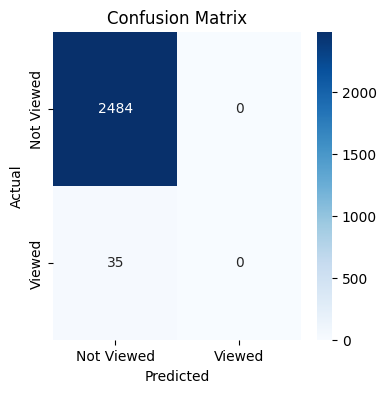

In [61]:
#%pip install seaborn
#import matplotlib.pyplot as plt
#import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Viewed", "Viewed"], yticklabels=["Not Viewed", "Viewed"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Components:
True Negatives (TN): 2484

The model correctly predicted 2484 instances as class 0 (not viewing the KB article).
False Positives (FP): 0

The model did not incorrectly predict any instances as class 1 (viewing the KB article) when they were actually class 0.
False Negatives (FN): 35

The model incorrectly predicted 35 instances as class 0 (not viewing the KB article) when they were actually class 1.
True Positives (TP): 0

The model did not correctly predict any instances as class 1 (viewing the KB article).

Key Observations:
Perfect Prediction for Class 0:

The model performs very well at identifying instances of class 0 (not viewing the KB article).
This is evident from the high True Negative (TN) count and no False Positives (FP).
Complete Failure for Class 1:

The model completely fails to predict class 1 (viewing the KB article).
This is seen in the 0 True Positives (TP) and the high False Negative (FN) count of 35.
Class Imbalance Impact:

The model is biased towards the majority class (class 0) due to the severe class imbalance, with 2484 instances of class 0 compared to only 35 of class 1.


In [64]:


# Redefine the RandomForestClassifier and retry with optimized settings
# Define the model and optimized parameter grid
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Perform Randomized Search for faster optimization
random_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    cv=3, 
    scoring='accuracy', 
    verbose=2
)
random_search.fit(X_train, y_train)

# Get the best parameters and evaluate the model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Make predictions and evaluate
y_pred = best_model.predict(X_test)
classification_report_result = classification_report(y_test, y_pred)

best_params, classification_report_result


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, min_samples_l

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

({'max_depth': 10,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 50},
 '              precision    recall  f1-score   support\n\n           0       0.99      1.00      0.99      2484\n           1       0.00      0.00      0.00        35\n\n    accuracy                           0.99      2519\n   macro avg       0.49      0.50      0.50      2519\nweighted avg       0.97      0.99      0.98      2519\n')

Observations
Class Imbalance Issue:

The model predicts the majority class (0: Not viewing the KB article) almost exclusively.
Precision, recall, and F1-score for the minority class (1: Viewing the KB article) are 0.
Accuracy:

The overall accuracy is 99%, but this is misleading due to the severe class imbalance.

Cross-validation of models

In [66]:


# Define models to evaluate
models = {
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "Logistic Regression": LogisticRegression(class_weight="balanced", max_iter=500, random_state=42),
    "Support Vector Machine": SVC(class_weight="balanced", random_state=42)
}

# Perform cross-validation for each model
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')  # 5-fold cross-validation
    results[model_name] = {
        "Mean Accuracy": scores.mean(),
        "Std Dev": scores.std()
    }

# Convert results to a DataFrame for display
results_df = pd.DataFrame(results).T
results_df


,Mean Accuracy,Std Dev
Random Forest,0.530052,0.235410
Logistic Regression,0.323859,0.181971
Support Vector Machine,0.386106,0.331062


Key Observations
Mean Accuracy:

Random Forest performed the best among the three models with a mean accuracy of 53%, suggesting it captures some patterns in the data better than Logistic Regression and SVM.
Logistic Regression had the lowest mean accuracy (32%), indicating it struggles with this dataset.
Support Vector Machine (SVM) showed moderate performance with a mean accuracy of 39%.

Standard Deviation:

Random Forest had a relatively lower standard deviation (0.235), indicating more consistent performance across the cross-validation folds.
Support Vector Machine (SVM) had the highest standard deviation (0.331), suggesting that its performance varied significantly across the folds, possibly due to sensitivity to data splits or class imbalance.

In [ ]:
Insights
Impact of Class Imbalance:

The low mean accuracy across all models indicates that class imbalance (majority class dominating) significantly affects the performance.
Models may predict the majority class (0: Not viewing KB articles) most of the time.
Model Suitability:

Random Forest shows promise for this dataset, likely due to its robustness to imbalanced data and ability to model complex patterns.
Recommendations
Address Class Imbalance:

Techniques like SMOTE (oversampling), undersampling, or class-weight adjustments can improve model performance for the minority class.
Explore Feature Engineering:

Include additional features (e.g., user behavior, engagement metrics) to improve predictive power.
Tune Hyperparameters:

Perform hyperparameter tuning using GridSearchCV or RandomizedSearchCV for Random Forest or SVM.

2.What KB articles users are reading from the same KB category?

In [69]:
# Identify the top 3 KB articles users are reading from the same KB content type

# Group by KB content type and KB article number, count the views
kb_views = data.groupby(['CONTENT_TYPE', 'REDACTED_ARTICLE_NUMBER']).size().reset_index(name='View_Count')

# Sort within each content type and get the top 5 for each
top_kb_articles = kb_views.sort_values(['CONTENT_TYPE', 'View_Count'], ascending=[True, False]).groupby('CONTENT_TYPE').head(3)
top_kb_articles

,CONTENT_TYPE,REDACTED_ARTICLE_NUMBER,View_Count
53,0,KB*****84,198
38,0,KB*****62,120
14,0,KB*****32,87
63,1,KB*****59,2
65,2,KB*****03,9
64,2,KB*****01,5
66,2,KB*****05,4
81,3,KB*****07,21
85,3,KB*****39,13
89,3,KB*****66,5
